In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read in the data
def read_file(filename):
    directory = '/content/drive/My Drive/learning_data/'
    location = directory + filename+'.csv'
    df = pd.read_csv(location, index_col=False)
    return df


In [4]:
## Read in all data files
X_test = read_file('X_test_yields')
X_val = read_file('X_val_yields')
Y_test = read_file('Y_test_yields')
Y_train = read_file('Y_train_yields')
Y_val = read_file('Y_val_yields')
X_train = read_file('X_train_yields')

In [5]:
## print shapes

print('X_test:',X_test.shape,
      '\nX_val:',X_val.shape,
      '\nX_train:',X_train.shape,
      '\nY_test:',Y_test.shape,
      '\nY_val:',Y_val.shape,
      '\nY_train:',Y_train.shape,

      )

X_test: (603, 1000) 
X_val: (1479, 1000) 
X_train: (17727, 1000) 
Y_test: (603, 1) 
Y_val: (1479, 1) 
Y_train: (17727, 1)


In [6]:
## getting a list of all the columns in X_train
X_list = list(X_train.columns)
X_list

['year',
 'state',
 'state_ansi',
 'county',
 'county_ansi',
 'ag_district',
 'ag_district_code',
 'irrig_yield',
 'non_irrig_yield',
 'all_ge_var',
 'ht_only',
 'bt_only',
 'stacked_genes',
 'jan_rain',
 'feb_rain',
 'mar_rain',
 'apr_rain',
 'may_rain',
 'jun_rain',
 'jul_rain',
 'aug_rain',
 'sep_rain',
 'oct_rain',
 'nov_rain',
 'dec_rain',
 'jan_temp',
 'feb_temp',
 'mar_temp',
 'apr_temp',
 'may_temp',
 'jun_temp',
 'jul_temp',
 'aug_temp',
 'sep_temp',
 'oct_temp',
 'nov_temp',
 'dec_temp',
 'state_county',
 'loc_georgia_appling',
 'loc_georgia_atkinson',
 'loc_georgia_bacon',
 'loc_georgia_baker',
 'loc_georgia_banks',
 'loc_georgia_bartow',
 'loc_georgia_ben hill',
 'loc_georgia_berrien',
 'loc_georgia_bleckley',
 'loc_georgia_brantley',
 'loc_georgia_brooks',
 'loc_georgia_bryan',
 'loc_georgia_bulloch',
 'loc_georgia_burke',
 'loc_georgia_calhoun',
 'loc_georgia_candler',
 'loc_georgia_carroll',
 'loc_georgia_catoosa',
 'loc_georgia_chattooga',
 'loc_georgia_clay',
 'loc_geo

In [7]:
X_train_ge = X_train[['all_ge_var',
 'ht_only',
 'bt_only',
 'stacked_genes'
]]

Creating defs for making reproduceable datasets to run many models to find the best predictions

In [8]:
## Create a list of columns that we are keeping

cols=['all_ge_var',
 'ht_only',
 'bt_only',
 'stacked_genes']

In [9]:
def col_keep(col_list,X):
  """takes a list of columns and the X df and returns only the wanted columns"""
  dropped_col = X[col_list]
  return dropped_col

In [10]:
## Create a function that removes the NAs from the below function

def remove_na(X,Y):
  """takes X and Y for either training / validation / test sets and removes na rows for both"""
  na_idx = X.isna().any(axis=1)
  Y_clean = Y[~na_idx]
  X_clean = X[~na_idx]

  return X_clean, Y_clean


First model, we will only look at GE data, then expand to looking at rain data.

In [11]:
## Process - start with a linear model to understand what would be the
## best options for ML and get to know the data better

In [12]:
### create X train,test,val datasets with only the wanted columns
## Keeping only the ge data

X_train_ge = col_keep(cols,X_train)
X_train_ge.shape
X_val_ge = col_keep(cols,X_val)
X_val_ge.shape
X_test_ge = col_keep(cols,X_test)
X_test_ge.shape

print('X_train_ge:', X_train_ge.shape,
      '\nX_val_ge:',X_val_ge.shape,
      '\nX_test_ge:',X_test_ge.shape
      )

X_train_ge: (17727, 4) 
X_val_ge: (1479, 4) 
X_test_ge: (603, 4)


In [13]:
## Removing the nulls from datasets:

## Train
X_train_ge_clean, Y_train_clean = remove_na(X_train_ge,Y_train)
print('X_train_ge_clean:', X_train_ge_clean.shape, '\nY_train_clean:', Y_train_clean.shape)

X_test_ge_clean, Y_test_clean = remove_na(X_test_ge,Y_test)
print('X_test_ge_clean:', X_test_ge_clean.shape, '\nY_test_clean:', Y_test_clean.shape)

X_val_ge_clean, Y_val_clean = remove_na(X_val_ge,Y_val)
print('X_val_ge_clean:', X_val_ge_clean.shape, '\nY_val_clean:', Y_val_clean.shape)



X_train_ge_clean: (12418, 4) 
Y_train_clean: (12418, 1)
X_test_ge_clean: (446, 4) 
Y_test_clean: (446, 1)
X_val_ge_clean: (1092, 4) 
Y_val_clean: (1092, 1)


 Begin investigating GE data to get ready for ML

In [14]:
## normalizing the datasets to 0-1 using the mean from the training set

X_train_mean = X_train_ge_clean.mean()
X_train_max = X_train_ge_clean.max()

print('X_train_mean:', X_train_mean,
      '\n\n\nX_train_max:',X_train_max)

X_train_mean: all_ge_var       72.723144
ht_only          12.385328
bt_only          13.959655
stacked_genes    46.392817
dtype: float64 


X_train_max: all_ge_var       97.0
ht_only          32.0
bt_only          41.0
stacked_genes    91.0
dtype: float64


In [15]:
## normalizing the ge data using

X_train_final = X_train_ge_clean/X_train_max
X_train_final.head()

,all_ge_var,ht_only,bt_only,stacked_genes
50,0.948454,0.125,0.04878,0.945055
51,0.948454,0.125,0.04878,0.945055
52,0.948454,0.125,0.04878,0.945055
53,0.948454,0.125,0.04878,0.945055
54,0.948454,0.125,0.04878,0.945055


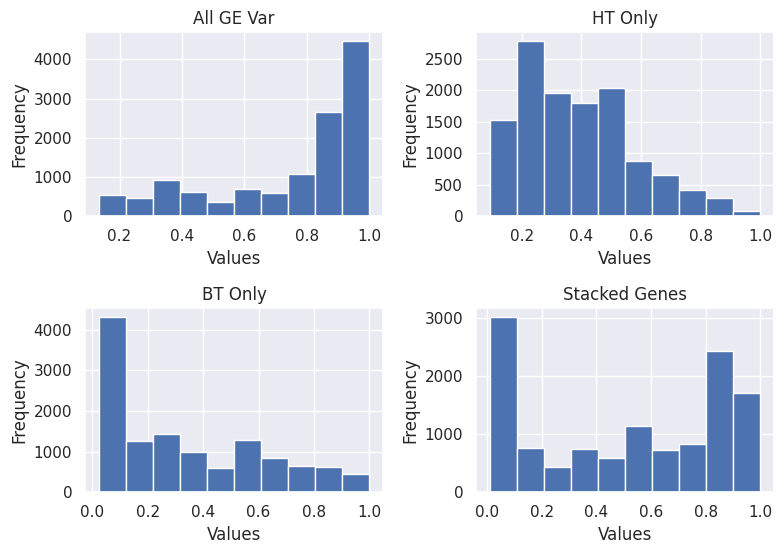

In [16]:
## plot histograms of all the training data

fig, axes = plt.subplots(2, 2, figsize=(8, 6))


axes[0, 0].hist(X_train_final['all_ge_var'])
axes[0, 0].set_title("All GE Var")
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xlabel('Values')

axes[0, 1].hist(X_train_final['ht_only'])
axes[0, 1].set_title("HT Only")
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xlabel('Values')

axes[1, 0].hist(X_train_final['bt_only'])
axes[1, 0].set_title("BT Only")
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlabel('Values')

axes[1, 1].hist(X_train_final['stacked_genes'])
axes[1, 1].set_title("Stacked Genes")
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlabel('Values')

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

All of these histograms are super different, so we should see which ones might be most likely to predict the corn yield the best. we can do this through linear regression or OLS before jumping into using all 4

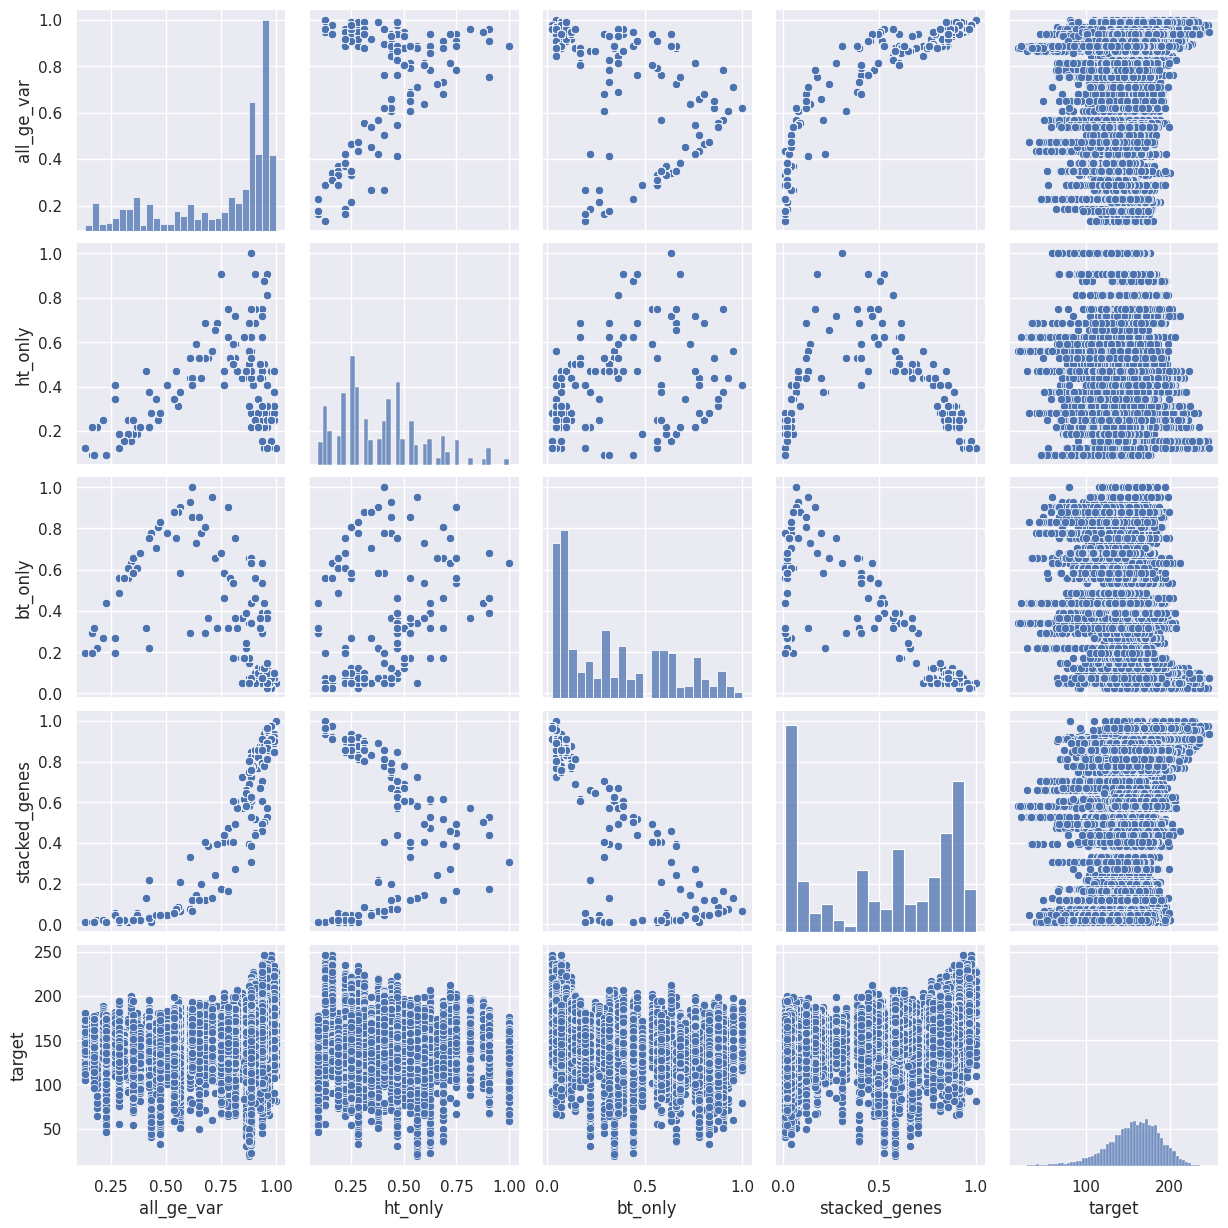

In [17]:
## use pairplot

comb_df = X_train_final.copy()
comb_df["target"]=Y_train_clean
sns.pairplot(comb_df)

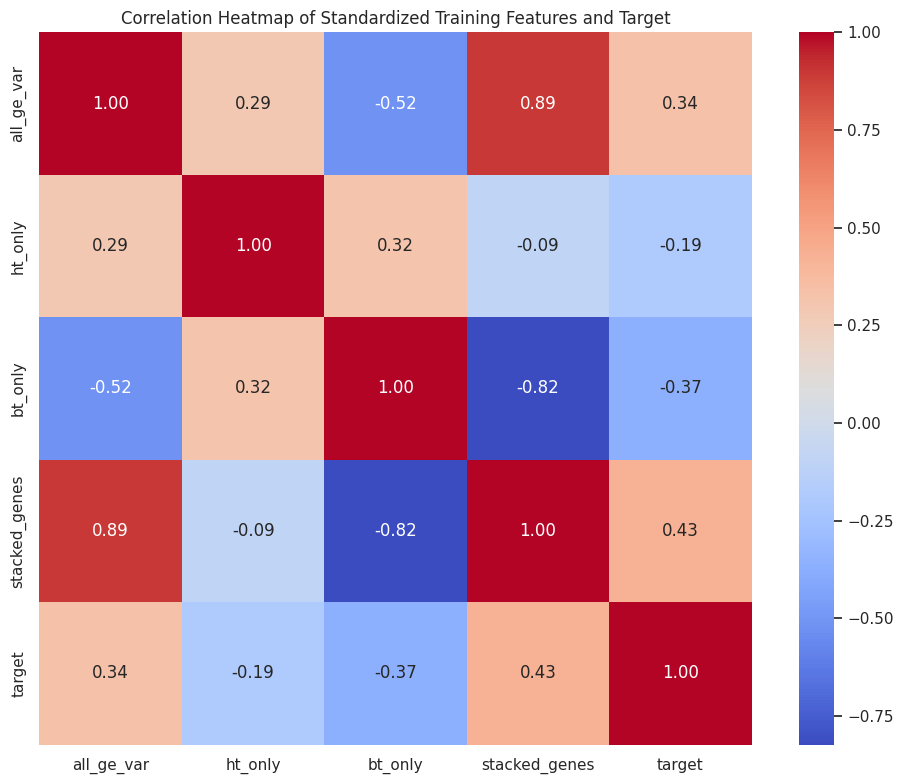

In [18]:
corr = comb_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Standardized Training Features and Target")
plt.tight_layout()
plt.show()

From this we can tell that all_gene_var and stacked_genes are the most redundant, but stacked_genes has a better corellation with the target. HT only has the lowest number on the heatmap and then Bt_only.

In [19]:
## using the mean Y as the baseline model

baseline_model = Y_train_clean.mean()
Y_train_std = Y_train_clean.std()
print('Baseline Mode:',baseline_model,
      '\n Baseline with std:', baseline_model+Y_train_std)

Baseline Mode: yield_bu_acre    156.719931
dtype: float64 
 Baseline with std: yield_bu_acre    189.318308
dtype: float64


In [20]:
## starting model with stacked genes only, then adding in all_ge_var
## based on heatmap plot


def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.

  model = tf.keras.Sequential()

  ## Adding 1 NN Layer
  model.add(tf.keras.layers.Dense(
        32,    # output dim
        input_shape=[num_features],  # input dim
        activation = 'relu',
        use_bias=True,               # use a bias (intercept) param
        kernel_initializer= tf.ones_initializer,  # initialize params to 1
        bias_initializer=tf.ones_initializer # initialize bias to 1
    ))

 ## Final output layer
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer= tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer # initialize bias to 1
  ))

  optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

  model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mse'] ,
    )

  return model



In [21]:
tf.random.set_seed(0)


def model_fit(X_model,Y_model, X_val, Y_val,epochs,learning_rate):
  num_feat = X_model.shape[1]

  ## build model
  model_tf = build_model(num_feat, learning_rate)

  history = model_tf.fit(
      x = X_model,
      y = Y_model,
      epochs=epochs,
      validation_data = (X_val, Y_val)
      )


  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(train_loss) + 1)

  # Print values
  print('train_loss:',train_loss[-1])
  print('val_loss:', val_loss[-1])

  # Plot the loss curves
  plt.figure(figsize=(4, 4))
  plt.plot(epochs, train_loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.title('Training and Validation Loss Over Epochs')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  return model_tf,history


In [22]:
X_train_final.columns

Index(['all_ge_var', 'ht_only', 'bt_only', 'stacked_genes'], dtype='object')

In [23]:
## finalize data


#### Normalize all X datasets
X_val_final = X_val_ge_clean/X_train_max
X_test_final = X_test_ge_clean/X_train_max


## remove un-needed colums from x for simpler start
### Stacked genes only
X_train_stacked = X_train_final[['stacked_genes']]
X_val_stacked = X_val_final[['stacked_genes']]
X_test_stacked = X_test_final[['stacked_genes']]

### Stacked genes and all_ge_var only
X_train_stacked_all_ge = X_train_final[['stacked_genes','all_ge_var']]
X_val_stacked_all_ge = X_val_final[['stacked_genes','all_ge_var']]
X_test_stacked_all_ge = X_test_final[['stacked_genes','all_ge_var']]


### change into tensors - STACKED
X_train_tensor_st = tf.convert_to_tensor(X_train_stacked)
Y_train_tensor = tf.convert_to_tensor(Y_train_clean)

X_val_tensor_st = tf.convert_to_tensor(X_val_stacked)
Y_val_tensor = tf.convert_to_tensor(Y_val_clean)

X_test_tensor_st = tf.convert_to_tensor(X_test_stacked)
Y_test_tensor = tf.convert_to_tensor(Y_test_clean)



### change into tensors - STACKED and All GE Var
X_train_tensor_sa = tf.convert_to_tensor(X_train_stacked_all_ge)

X_val_tensor_sa = tf.convert_to_tensor(X_val_stacked_all_ge)

X_test_tensor_sa = tf.convert_to_tensor(X_test_stacked_all_ge)


In [24]:
print( "X_train_tensor_st Shape:", X_train_tensor_st.shape,
      "\nX_train_tensor_sa Shape:", X_train_tensor_sa.shape,
      '\n Y_train_tensor Shape:', Y_train_tensor.shape,

      '\n\n X_val_tensor_st:', X_val_tensor_st.shape,
       '\n X_val_tensor_sa:', X_val_tensor_sa.shape,
       '\n Y_val_tensor:', Y_val_tensor.shape,

       '\n\n X_test_tensor_st:',X_test_tensor_st.shape,
       '\n X_test_tensor_sa:',X_test_tensor_sa.shape,
       '\n Y_test_tensor:',Y_test_tensor.shape
       )

X_train_tensor_st Shape: (12418, 1) 
X_train_tensor_sa Shape: (12418, 2) 
 Y_train_tensor Shape: (12418, 1) 

 X_val_tensor_st: (1092, 1) 
 X_val_tensor_sa: (1092, 2) 
 Y_val_tensor: (1092, 1) 

 X_test_tensor_st: (446, 1) 
 X_test_tensor_sa: (446, 2) 
 Y_test_tensor: (446, 1)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12209.1797 - mae: 106.5792 - mse: 12209.1797 - val_loss: 14594.4189 - val_mae: 117.2431 - val_mse: 14594.4189
Epoch 2/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11490.1846 - mae: 103.2038 - mse: 11490.1846 - val_loss: 13594.2080 - val_mae: 112.9016 - val_mse: 13594.2080
Epoch 3/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10775.0771 - mae: 99.7341 - mse: 10775.0771 - val_loss: 12604.4600 - val_mae: 108.4352 - val_mse: 12604.4600
Epoch 4/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10066.3721 - mae: 96.1724 - mse: 10066.3721 - val_loss: 11629.2812 - val_mae: 103.8656 - val_mse: 11629.2812
Epoch 5/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9366.8955 - mae: 92.5236 - mse: 9366.8955 - val_loss: 10672.8311 - val_mae: 99.2133 - val_mse: 10672.8311
Epoch 6/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8679.4805 - mae: 88.7976 - mse: 8679.4805 - val_loss: 9739.1426 - val_mae: 94.4663 - val_mse: 9739.1426
Epo

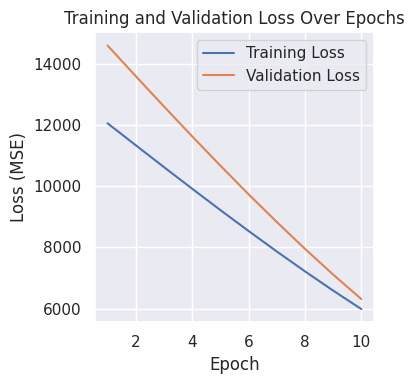

In [25]:
# Test run model

baseline_model_st,st_history = model_fit(X_train_tensor_st,Y_train_tensor,X_val_tensor_st,Y_val_tensor,10,0.0001)

Epoch 1/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9210.7656 - mae: 90.4509 - mse: 9210.7656 - val_loss: 1825.1388 - val_mae: 37.7846 - val_mse: 1825.1388
Epoch 2/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1660.5087 - mae: 33.8195 - mse: 1660.5087 - val_loss: 883.4253 - val_mae: 22.3434 - val_mse: 883.4253
Epoch 3/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1138.8400 - mae: 26.4846 - mse: 1138.8400 - val_loss: 875.0591 - val_mae: 22.3669 - val_mse: 875.0591
Epoch 4/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1045.1959 - mae: 25.2818 - mse: 1045.1959 - val_loss: 864.7360 - val_mae: 22.7029 - val_mse: 864.7360
Epoch 5/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 976.7277 - mae: 24.4218 - mse: 976.7277 - val_loss: 867.5140 - val_mae: 23.1577 - val_mse: 867.5140
Epoch 6/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 932.5048 - mae: 23.8389 - mse: 932.5048 - val_loss: 878.1270 - val_mae: 23.6280 - val_mse: 878.1270
Epoch 7/30
389/389 ━━━━━━━━━━━

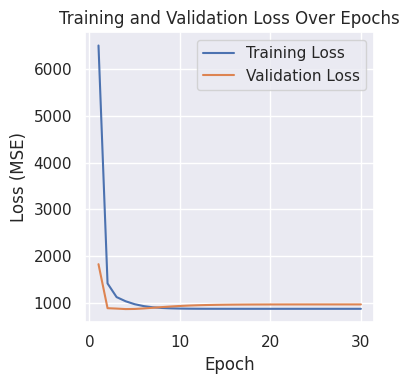

In [26]:
st_train_only,st_history_2 = model_fit(X_train_tensor_st,Y_train_tensor,X_val_tensor_st,Y_val_tensor,30,0.00189)

Epoch 1/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7646.1709 - mae: 82.6896 - mse: 7646.1709 - val_loss: 8046.9927 - val_mae: 85.2370 - val_mse: 8046.9927
Epoch 2/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6875.7720 - mae: 77.9521 - mse: 6875.7720 - val_loss: 7020.4678 - val_mae: 79.1918 - val_mse: 7020.4678
Epoch 3/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6141.2202 - mae: 73.1578 - mse: 6141.2202 - val_loss: 6054.1841 - val_mae: 73.0820 - val_mse: 6054.1841
Epoch 4/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5447.6289 - mae: 68.3344 - mse: 5447.6289 - val_loss: 5156.1978 - val_mae: 66.9952 - val_mse: 5156.1978
Epoch 5/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4800.4961 - mae: 63.5173 - mse: 4800.4961 - val_loss: 4333.8872 - val_mae: 60.9630 - val_mse: 4333.8872
Epoch 6/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4204.8550 - mae: 58.7598 - mse: 4204.8550 - val_loss: 3593.7961 - val_mae: 55.0496 - val_mse: 3593.7961
Epoch 7/10
389/3

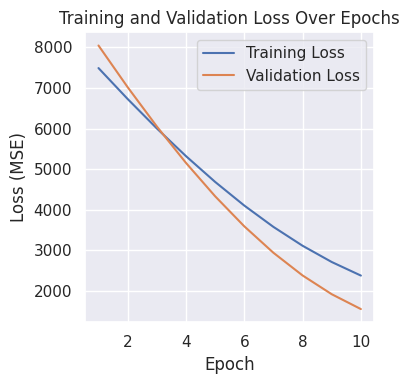

In [27]:
sa_train_baseline, sa_history_baseline = model_fit(X_train_tensor_sa,Y_train_tensor,X_val_tensor_sa,Y_val_tensor,10,0.0001)

Epoch 1/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1410.3038 - mae: 28.8383 - mse: 1410.3038 - val_loss: 1169.2565 - val_mae: 29.0000 - val_mse: 1169.2565
Epoch 2/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 899.5154 - mae: 23.2856 - mse: 899.5154 - val_loss: 1048.7260 - val_mae: 27.0784 - val_mse: 1048.7260
Epoch 3/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 878.2819 - mae: 23.0215 - mse: 878.2819 - val_loss: 908.3919 - val_mae: 24.4786 - val_mse: 908.3919
Epoch 4/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 874.5352 - mae: 22.9726 - mse: 874.5352 - val_loss: 887.2663 - val_mae: 23.9788 - val_mse: 887.2663
Epoch 5/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 873.9301 - mae: 22.9668 - mse: 873.9301 - val_loss: 888.7034 - val_mae: 24.0183 - val_mse: 888.7034
Epoch 6/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 874.1685 - mae: 22.9713 - mse: 874.1685 - val_loss: 887.4526 - val_mae: 23.9869 - val_mse: 887.4526
Epoch 7/10
389/389 ━━━━━━━━━━━━━━━

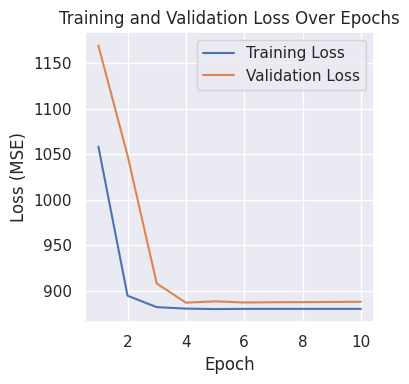

In [28]:
sa_train_only, sa_history = model_fit(X_train_tensor_sa,Y_train_tensor,X_val_tensor_sa,Y_val_tensor,10,0.1)

In [30]:
results = sa_train_only.evaluate(X_test_tensor_sa, Y_test_tensor)
results

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1017.6027 - mae: 26.2819 - mse: 1017.6027 


[842.31005859375, 23.192956924438477, 842.31005859375]

Choosing to use the model with Stacked and All GE because it generalizes much better than the previous model, even though both looked good on the training data.

In [ ]:
## This model shows strong generalization across training, validation and test datasets.

In [31]:
history_dict = sa_history.history  # or whatever your history variable is
final_train_loss = history_dict["loss"][-1]
print(f"Final Training Loss (MSE): {final_train_loss:.2f} bu²/acre²")

if "mae" in history_dict and "val_mae" in history_dict:
    final_train_mae = history_dict["mae"][-1]
    final_val_mae = history_dict["val_mae"][-1]

    print(f"Final Training MAE: {final_train_mae:.2f} bu/acre")
    print(f"Final Validation MAE: {final_val_mae:.2f} bu/acre")

if "mse" in history_dict and "val_mse" in history_dict:
    final_train_mse = history_dict["mse"][-1]
    final_val_mse = history_dict["val_mse"][-1]

    train_rmse = final_train_mse ** 0.5
    val_rmse = final_val_mse ** 0.5

    Y_mean_scalar = np.mean(Y_train_tensor)  # Only for % comparison

    pct_rmse_train = train_rmse / Y_mean_scalar
    pct_rmse_val = val_rmse / Y_mean_scalar

    print("\n============================")
    print("📈 MSE Comparison (Original Scale)")
    print(f"Final Training MSE: {final_train_mse:.2f} bu²/acre²")
    print(f"Final Training RMSE: {train_rmse:.2f} bu/acre")
    print(f"Pct RMSE off mean Yield (train): {pct_rmse_train:.2%}")

    print("\n---")

    print(f"Final Validation MSE: {final_val_mse:.2f} bu²/acre²")
    print(f"Final Validation RMSE: {val_rmse:.2f} bu/acre")
    print(f"Pct RMSE off mean Yield (val): {pct_rmse_val:.2%}")


Final Training Loss (MSE): 880.46 bu²/acre²
Final Training MAE: 22.93 bu/acre
Final Validation MAE: 24.01 bu/acre

📈 MSE Comparison (Original Scale)
Final Training MSE: 880.46 bu²/acre²
Final Training RMSE: 29.67 bu/acre
Pct RMSE off mean Yield (train): 18.93%

---
Final Validation MSE: 888.25 bu²/acre²
Final Validation RMSE: 29.80 bu/acre
Pct RMSE off mean Yield (val): 19.02%
